# INTRODUCTION

**Goal**

The goal becomes to find a personalized ranking function that is better than item popularity, so we can better satisfy members with varying tastes.

One obvious way to approach this is to use the member’s predicted rating of each item as an adjunct to item popularity. 
There are many ways one could construct a ranking function ranging from simple scoring methods, to pairwise preferences, to optimization over the entire ranking. 

**Scoring Approach**

For the purposes of illustration, let us start with a very simple scoring approach by choosing our ranking function to be a linear combination of popularity and predicted rating. This gives an equation of the form frank(u,v) = w1 p(v) + w2 r(u,v) + b, where u=user, v=video item, p=popularity and r=predicted rating.

**Limitations**

1. Assumed that inference is done only for the rated movies and by the users who already rated.

**Baseline**

We already mentioned item popularity as a baseline. But, there are many ways to compute popularity. We can compute it over various time ranges, for instance hourly, daily, or weekly. Or, we can group members by region or other similarity metrics and compute popularity within that group.

**Online System**

An online machine learning system has a continuous stream of new input data. You’ll need to train your DNN on the new data. However, if you retrain your DNN from scratch, then your embeddings will be different because DNNs are initialized with random weights. Instead, always warm-start the DNN with the existing weights and then update the DNN with new data.

# LIBRARIES

In [1]:
import pandas as pd

import numpy as np

from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

from Movie_Recommender import SourceData, PreProcessing, DeepLearning, Recommendation

In [2]:
np.set_printoptions(suppress=True)

# DATA SOURCE

Data is downloaded from the link https://www.kaggle.com/datasets/san1201/movielens1m?select=ml-1m.train.csv

## Users

In [3]:
dfUsers = SourceData.dfGetUsers()
dfCopyUsers = dfUsers.copy()
dfUsers.head()

,gender,age,occupation,zip_code
user_id,,,,
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455


## Movies

In [4]:
dfMovies = SourceData.dfGetMovies()
dfCopyMovies = dfMovies.copy()
dfMovies.head()

,title,genres
movie_id,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


## Ratings

In [5]:
dfRatings = SourceData.dfGetRatings()
dfCopyRatings = dfRatings.copy()
dfRatings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


# PREPROCESSING

## Extract Year of Release of Movies

After moving the ""year_of_release"" from ""title"" there can be duplicated names. It means that same movie name has different release years. (e.g., <i>Hamlet</i>)

In [6]:
dfMovies = PreProcessing.dfExtractYearOfReleaseOfMovies(dfMovies)

In [7]:
dfMovies[dfMovies['title'] == 'Hamlet']

,title,genres,year_of_release
movie_id,,,
1411,Hamlet,Drama,1996
1941,Hamlet,Drama,1948
2820,Hamlet,Drama,1964
3598,Hamlet,Drama,2000
3723,Hamlet,Drama,1990


## Transform Genres of Movies to One Hot Vector

In [8]:
dfMovies = PreProcessing.dfTransformGenresToOneHot(dfMovies)
dfMovies

,title,genres,year_of_release,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,Animation|Children's|Comedy,1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jumanji,Adventure|Children's|Fantasy,1995,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men,Comedy|Romance,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale,Comedy|Drama,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Father of the Bride Part II,Comedy,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,Meet the Parents,Comedy,2000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3949,Requiem for a Dream,Drama,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3950,Tigerland,Drama,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Merge Datasets

In [9]:
dfPreprocessed = PreProcessing.dfMergeRatingsMoviesUsers(dfRatings, dfMovies, dfUsers)

## Encode Movie ID and Item Id in Ratings Dataset

In [10]:
dfPreprocessed = PreProcessing.oEncodeFieldWithOrdinalEncoder(dfPreprocessed, 'movie_id')
dfPreprocessed = PreProcessing.oEncodeFieldWithOrdinalEncoder(dfPreprocessed, 'user_id')

## Split Train-Validation-Test

In [11]:
ixTrain, ixValidation , ixTest = PreProcessing.ixSplitTrainValidationTest(dfPreprocessed)

# DEEP LEARNING MODEL

## Identify Unique Number of Movies and Users in Ratings Dataset

In [12]:
iNrOfMovies, iNrOfUsers = DeepLearning.iGetNrOfUniqueMoviesUsers(dfPreprocessed)

## Build Input Datasets

In [13]:
aMovie_X_Train, aMovie_X_Validation, aMovie_X_Test, aUser_X_Train, aUser_X_Validation, aUser_X_Test = DeepLearning.aBuildInputDatasets(dfPreprocessed, ixTrain, ixValidation, ixTest)

## Build Output Datasets

In [14]:
a_y_Train, a_y_Validation, a_y_Test = DeepLearning.aBuildOutputDatasets(dfPreprocessed, ixTrain, ixValidation,ixTest)

## Build Model

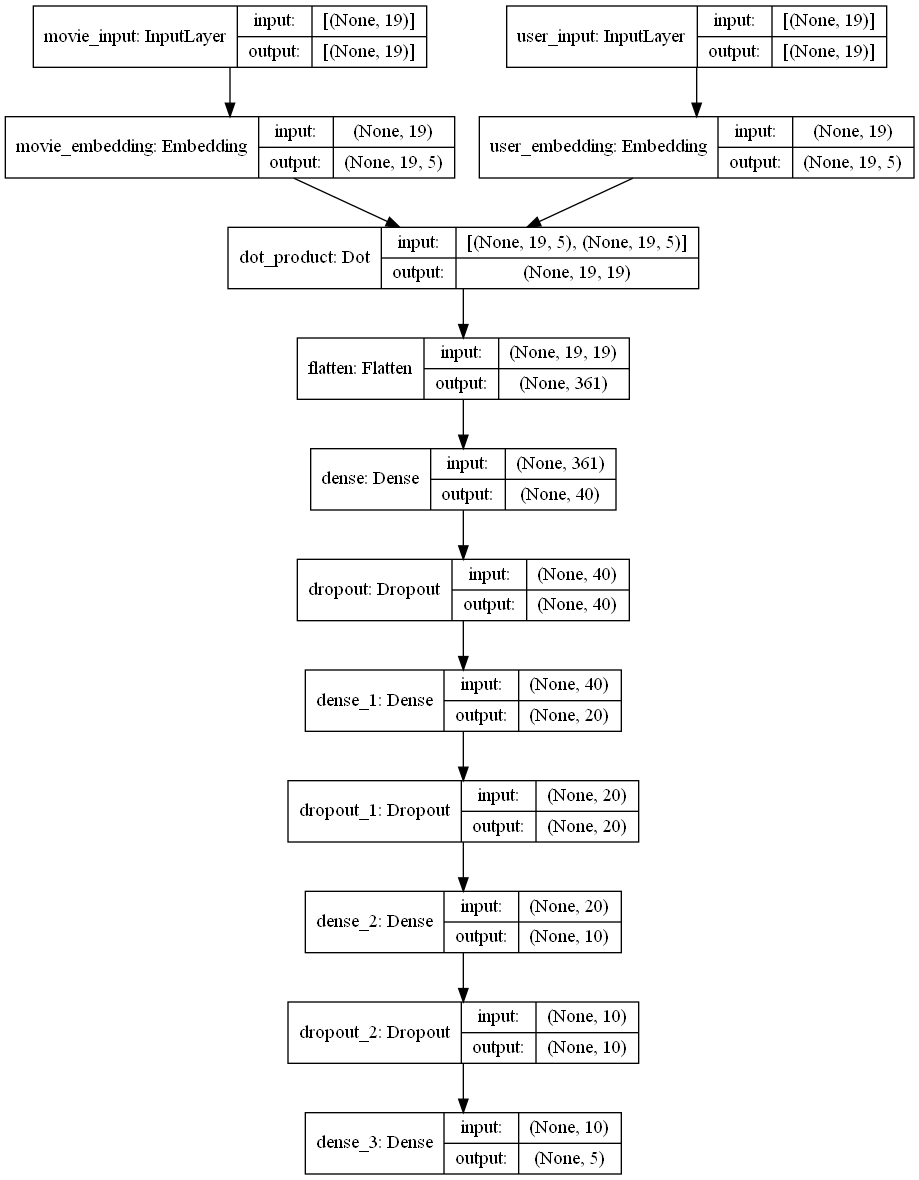

In [16]:
oModelRatingEstimator = DeepLearning.oBuildModel(iNrOfMovies, iNrOfUsers)
plot_model(oModelRatingEstimator, show_shapes=True)

## Fit Model

In [17]:
dfHistory = DeepLearning.dfFitModel(oModelRatingEstimator, aMovie_X_Train, aUser_X_Train,a_y_Train, aMovie_X_Validation, aUser_X_Validation, a_y_Validation)

Epoch 1/1000
171/171 [==============================] - 4s 16ms/step - loss: 0.4775 - val_loss: 0.4315
Epoch 2/1000
171/171 [==============================] - 3s 15ms/step - loss: 0.4392 - val_loss: 0.4194
Epoch 3/1000
171/171 [==============================] - 3s 15ms/step - loss: 0.4284 - val_loss: 0.4154
Epoch 4/1000
171/171 [==============================] - 3s 15ms/step - loss: 0.4228 - val_loss: 0.4126
Epoch 5/1000
171/171 [==============================] - 3s 15ms/step - loss: 0.4188 - val_loss: 0.4108
Epoch 6/1000
171/171 [==============================] - 3s 15ms/step - loss: 0.4160 - val_loss: 0.4101
Epoch 7/1000
171/171 [==============================] - 3s 15ms/step - loss: 0.4140 - val_loss: 0.4089
Epoch 8/1000
171/171 [==============================] - 3s 15ms/step - loss: 0.4122 - val_loss: 0.4075
Epoch 9/1000
171/171 [==============================] - 3s 15ms/step - loss: 0.4108 - val_loss: 0.4069
Epoch 10/1000
171/171 [==============================] - 3s 19ms/step - l

INFO:tensorflow:Assets written to: Models\rating_estimator_model\assets


INFO:tensorflow:Assets written to: Models\rating_estimator_model\assets


<AxesSubplot:ylabel='loss'>

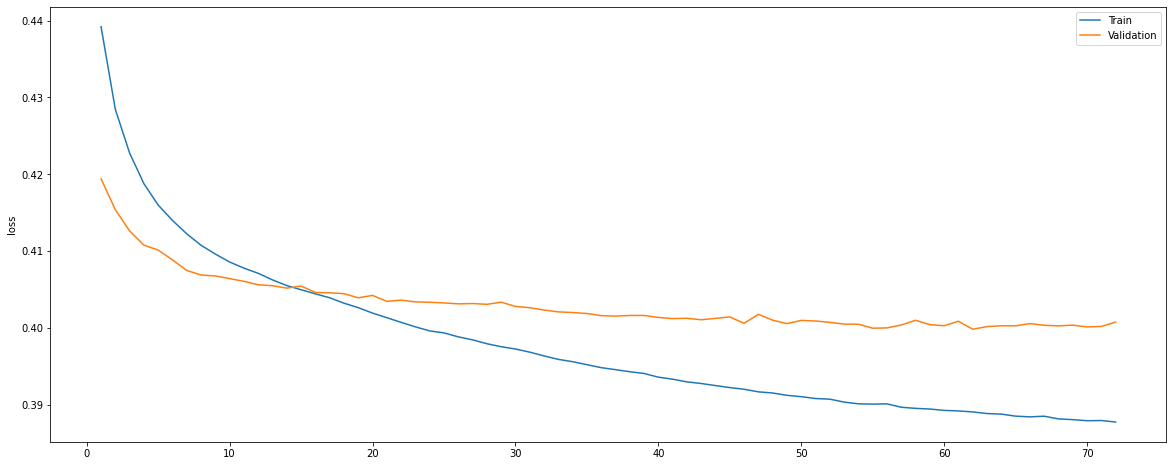

In [18]:
plt.figure(figsize = (20, 8))
sns.lineplot(data = dfHistory['loss'].iloc[1:], legend = True, label = 'Train')
sns.lineplot(data = dfHistory['val_loss'].iloc[1:], legend = True, label = 'Validation')

## Test Model

In [19]:
pred = DeepLearning.aPredict(aMovie_X_Test, aUser_X_Test, oModelRatingEstimator)
ground_true = DeepLearning.aDecodeOutput(a_y_Test)

DeepLearning.dfGetRegressionMetrics(ground_true, pred)

,Value
Mean Squared Error,0.99
Root Mean Squared Error,0.99
Mean Absolute Error,0.67
R2 Score,0.21


              precision    recall  f1-score   support

           1       0.50      0.29      0.37      8484
           2       0.38      0.15      0.21     16088
           3       0.41      0.42      0.42     38955
           4       0.45      0.62      0.53     52609
           5       0.56      0.45      0.49     33896

    accuracy                           0.46    150032
   macro avg       0.46      0.39      0.40    150032
weighted avg       0.46      0.46      0.45    150032



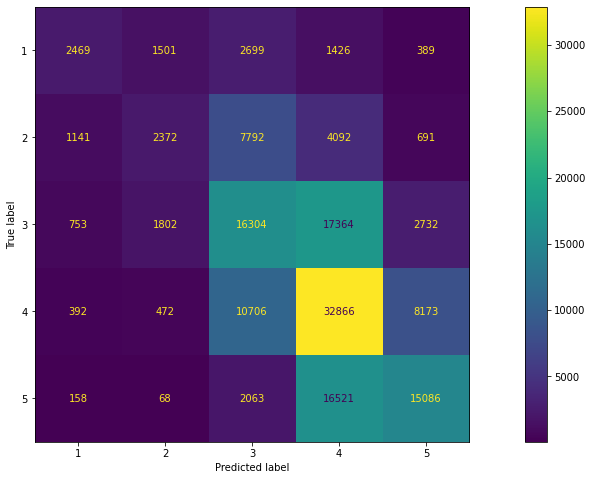

In [20]:
print(classification_report(ground_true, pred))

aConfMatr = confusion_matrix(ground_true, pred, labels = np.unique(ground_true))
oConfMatr = ConfusionMatrixDisplay(aConfMatr, display_labels  = np.unique(ground_true))
fig, ax = plt.subplots(figsize=(20,8))
oConfMatr.plot(ax=ax)

<AxesSubplot:ylabel='Count'>

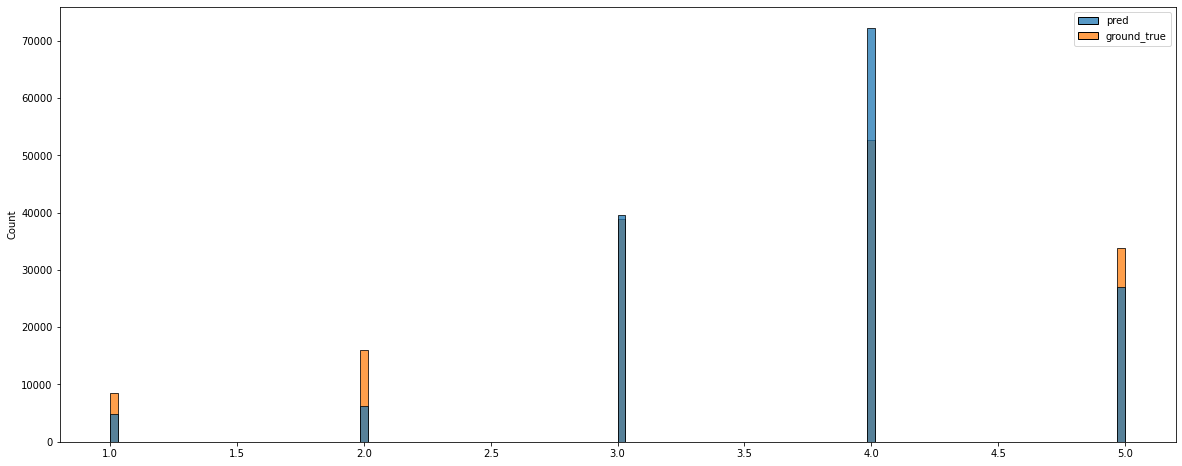

In [21]:
dfComparison = pd.DataFrame(index = ixTest)
dfComparison['pred'] = pred
dfComparison['ground_true'] = ground_true

plt.figure(figsize = (20, 8))
sns.histplot(data = dfComparison)

# RECOMMENDATION

The ones who has smallest **cosine** distance is the most similar to each other.

In [22]:
iUserID = 205

oRecommender = Recommendation(iUserID, dfPreprocessed)

In [23]:
aMaxSimilarNUsers = oRecommender.aGetMostSimilarUsers()

In [24]:
dfSimilarUserRatings = oRecommender.dfGetMovieIdsRatedByMostSimilarUsers(aMaxSimilarNUsers)
dfSimilarUserRatings = oRecommender.dfExcludeMovieIdsThatAreAlreadyRatedByUser(dfSimilarUserRatings)
dfSimilarUserRatings = oRecommender.dfGetExpectedRatingsForSimilarUserRatings(dfSimilarUserRatings)
dfSimilarUserRatings = oRecommender.dfCalculateFinalExpectedScores(dfSimilarUserRatings)


In [25]:
oRecommender.dfGetRecommendations(dfSimilarUserRatings)

,title,genres,expected_rating
0,Fargo (1996),Crime|Drama|Thriller,5.0
1,GoodFellas (1990),Crime|Drama,5.0
2,Austin Powers: International Man of Mystery (1...,Comedy,5.0
3,Blade Runner (1982),Film-Noir|Sci-Fi,5.0
4,Bound (1996),Crime|Drama|Romance|Thriller,5.0


## User History

In [26]:
oRecommender.dfGetUserHistory()

,title,genres,rating
152,Rosencrantz and Guildenstern Are Dead (1990),Comedy|Drama,5
60,"Ghost and Mrs. Muir, The (1947)",Drama|Romance,5
71,Beyond the Mat (2000),Documentary,5
132,"Big Blue, The (Le Grand Bleu) (1988)",Adventure|Romance,5
133,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama,5
...,...,...,...
96,"Little Shop of Horrors, The (1960)",Comedy|Horror,2
103,Mary Poppins (1964),Children's|Comedy|Musical,1
11,"Princess Mononoke, The (Mononoke Hime) (1997)",Action|Adventure|Animation,1
8,Stand by Me (1986),Adventure|Comedy|Drama,1


# FUTURE STEPS

1. Book https://www.amazon.com/Recommender-Systems-Introduction-Dietmar-Jannach/dp/0521493366 should be read.
1. For Embedding layer of movies, vocabulary of **title** of movie can be used.
1. Scalibility is a challage. When there are millions of items. 
1. It is challange When a new user or new movie is added. Or when a person starts to rate.
1. Sequence of user ratings is important
1. Large dataset with a lof of users and movies are problem. Pandas will give out of memery error. 
1. Cross-Validation could be applied.
1. Don't recommend second version of series if the user did not watch the first ones.

# REFERENCES

1. https://developers.google.com/machine-learning/clustering/similarity/supervised-similarity
1. https://towardsdatascience.com/recommender-systems-from-learned-embeddings-f1d12288f278#:~:text=Embeddings%20are%20vector%20representations%20of,and%20user%20IDs%20as%20embeddings.
1. https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429
1. https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-2-d9b96aa399f5
1. https://blog.tensorflow.org/2020/09/introducing-tensorflow-recommenders.html
1. http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf